Note that because of the number of images and their size, for now they're kept out of the github repo. In addition to the training set I analyze here, both datasets also have test and validation splits.

In [197]:
import numpy as np 
import cv2
import random 
import os 
import pandas as pd
import json
from pprint import pprint
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

Annotation data was collected from the original data sources (Sheng et al and Objects365), cleaned up on the Roboflow platform, and re-exported in COCO format. I created augmented versions of images to increase the size of the training set by adding randomized small rotations and horizontal flips. There are two datasets here, one of full images possibly containing more than one camera in the frame, and one of images cropped to just the bounding box of a single camera instance.

In [198]:
with open('../data/cams_coco/train/_annotations.coco.json') as f:
  cams_full = json.load(f)

with open('../data/cams_crop/train/_annotations.coco.json') as f:
  cams_crop = json.load(f)
  
print(f'keys in full images: { cams_full.keys() }')
print(f'keys in cropped images: { cams_crop.keys() }')

print(f'\nexample of annotations for a single image:')
pprint(cams_full['annotations'][0])

print(f'\nexample of metadata for a single image:')
pprint(cams_full['images'][0])

keys in full images: dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])
keys in cropped images: dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

example of annotations for a single image:
{'area': 135,
 'bbox': [554, 246, 15, 9],
 'category_id': 1,
 'id': 0,
 'image_id': 0,
 'iscrowd': 0,
 'segmentation': []}

example of metadata for a single image:
{'date_captured': '2023-05-20T17:59:59+00:00',
 'file_name': 'x6NQQwp1XjZv43rNbMBvEA_265_jpg.rf.842d5c5e0d08e84f97063f79c63fe332.jpg',
 'height': 640,
 'id': 0,
 'license': 1,
 'width': 640}


In [199]:
meta_dfs = {}
meta_dfs['ann'] = {}
meta_dfs['img'] = {}
# ann_df = {}
# img_df = {}
for i, d in [('full', cams_full), ('crop', cams_crop)]:
  ann = pd.DataFrame(d['annotations'])
  ann = ann.set_index('id')
  ann = ann.drop(columns = ['segmentation', 'iscrowd'])
  meta_dfs['ann'][i] = ann
  
  img = pd.DataFrame(d['images'])
  img = img.set_index('id')
  img = img.drop(columns = ['license'])
  meta_dfs['img'][i] = img
 
meta_dfs = {
  k: pd.concat(v.values(), keys = v.keys(), names = ['type']) for k, v in meta_dfs.items()
}

Because there can be multiple cameras identified in one full image, the number of annotations in the full images dataset (4,610) is greater than the number of images in that same dataset (2,512). 

In [200]:
{ k: v.groupby('type').count().iloc[:, 0] for k, v in meta_dfs.items() }

{'ann': type
 crop    1045
 full    4610
 Name: image_id, dtype: int64,
 'img': type
 crop    1045
 full    2512
 Name: file_name, dtype: int64}

Categories to use for classification: 1 = directional, 2 = globe; 3 = not classified (Objects365 images are not classified). These are close to evenly split, with 48% being directional cameras. Directional cameras have a smaller mean bounding box size, as their bounding boxes are more oblong. All the cropped images are very small and blurry, however, which makes classification difficult. Full sized images are uniformly 640 x 640 pixels, but cropped images have mean dimensions of only 12 x 14 pixels.

In [201]:
meta_dfs['ann'].loc['crop', :] \
  .groupby('category_id') \
  .agg({'image_id': 'nunique', 'area': 'mean'}) \
  .loc[[1, 2], :]

,image_id,area
category_id,,
1,381,100.881890
2,418,134.880383


In [202]:
meta_dfs['img'].groupby('type').agg({'height': 'mean', 'width': 'mean'})

,height,width
type,,
crop,12.155981,14.32823
full,640.000000,640.00000


In [203]:
anns_x_img = pd.merge(
  meta_dfs['ann'].loc['full', :],
  meta_dfs['img'].loc['full', :],
  how = 'left', left_on = 'image_id', right_index = True
)
anns_x_img['n_per_img'] = 1 
anns_x_img = anns_x_img.groupby('image_id').agg({'n_per_img': 'sum'})

The vast majority of images have only 1 or 2 cameras marked in them. Some  have upwards of 15; checking for anomalies, it does seem realistic for some indoor scenes from the Objects365 data to have many cameras. For example, the highest number of annotations in an image is 24; this occurs 3 times, but all are augmentations of one image:

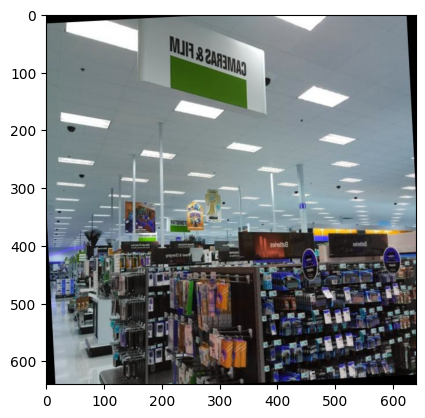

In [204]:
many_cams = anns_x_img.loc[anns_x_img['n_per_img'] > 20, :].index
  
many_cam_id = meta_dfs['img'].iloc[many_cams, :]['file_name'].values[0]
many_cam_img = cv2.imread(os.path.join('../data/cams_coco/train', many_cam_id))
plt.imshow(many_cam_img)
plt.show()

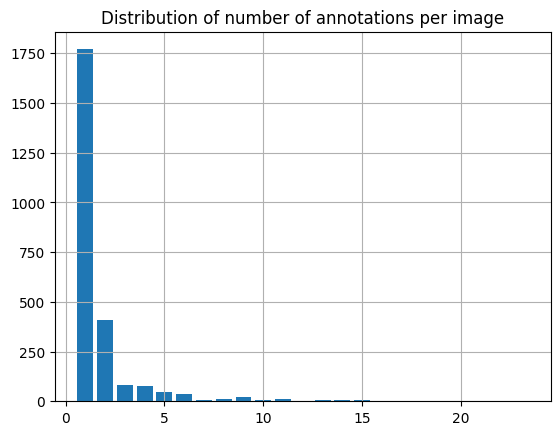

In [205]:
anns_hist = anns_x_img['n_per_img'].hist(bins = range(1, 25), rwidth = 0.8, align = 'left')
anns_hist.set_title('Distribution of number of annotations per image')
plt.show()

Finally, a sample of some of the cropped images:

category: 1


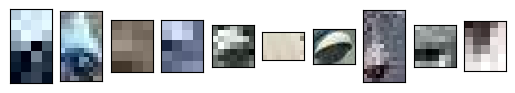

category: 2


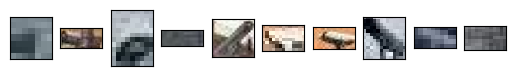

In [206]:
crop_sample = meta_dfs['ann'].loc['crop'].groupby('category_id').head(10)
crop_sample = crop_sample.loc[crop_sample['category_id'].isin([1, 2]), :]
crop_sample = crop_sample.merge(meta_dfs['img'].loc['crop', :], 
                                how = 'left', left_on = 'image_id', right_index = True)
crop_sample = crop_sample.loc[:, ['image_id', 'category_id', 'file_name']]

  
for cat_id in [1, 2]:
  cat_sample = crop_sample.loc[crop_sample['category_id'] == cat_id, :]
  imgs = [cv2.imread(os.path.join('../data/cams_crop/train', f))
          for f in cat_sample['file_name'].values]
  n = len(imgs)
  fig, axs = plt.subplots(ncols = n, squeeze = False)
  for i in range(n):
    img_grid = plt.subplot(1, 10, i + 1)
    img_grid.imshow(imgs[i])
    img_grid.set_xticks([])
    img_grid.set_yticks([])
  print(f'category: { cat_id }')
  plt.show()
  